# 第5章 微调和引导

基本概念：
- 微调：在新的数据集上重新训练已有的模型，以改变原有的输出类型。
- 引导：在推理阶段引导现有模型的生成过程，以获取额外的控制。
- 条件生成：在训练过程中产生的额外信息，导入到模型中进行预测，通过输入相关信息作为条件来控制模型的生成。

条件信息输入模型的方法：
- 将条件信息作为额外的通道输入UNet模型。
- 将条件信息转换成embedding，然后将embedding通过投影层映射来改变其通道数，从而可以对齐模型中间层的输出通道，最后将embedding加到中间层的输出上。
- 添加带有交叉注意力（cross-attention）机制的网络层。

## 5.1 环境准备

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDIMScheduler, DDPMPipeline
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

 ## 5.2 载入一个预训练过的管线

In [6]:
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to(device);

diffusion_pytorch_model.safetensors not found


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

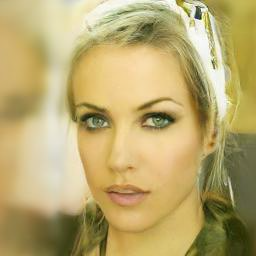

In [7]:
images = image_pipe().images
images[0]

## 5.3 DDIM——更快的采样过程

为了生成图像，从随机噪声开始，在每个时间步都将带有噪声的输入送入模型，并将模型的预测结果再次输入step()函数，其实整个过程是从高噪声到低噪声。

In [8]:
# 创建一个新的调度器，并设置推理迭代次数
scheduler = DDIMScheduler.from_pretrained("google/ddpm-celebahq-256")
scheduler.set_timesteps(num_inference_steps=40)

0it [00:00, ?it/s]

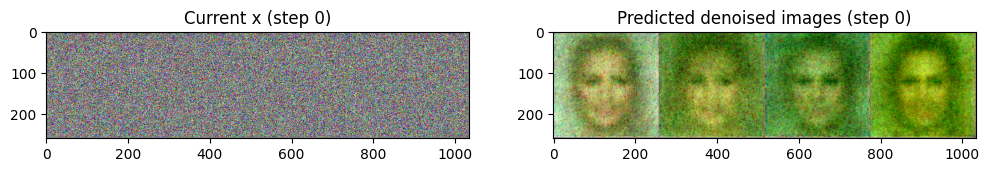

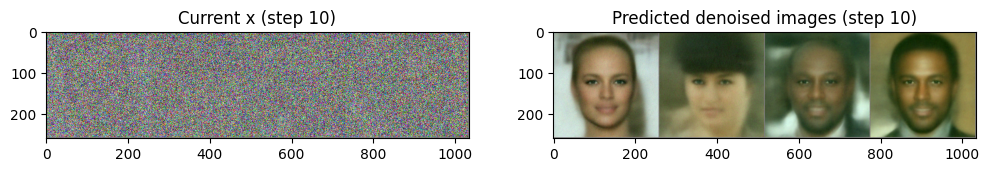

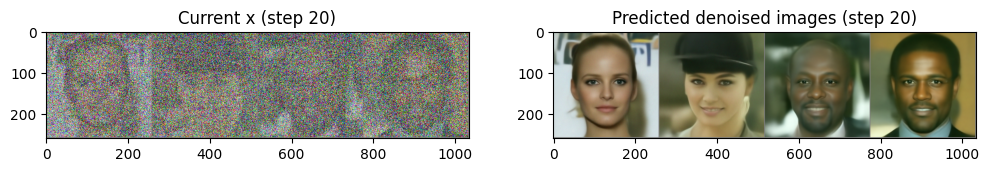

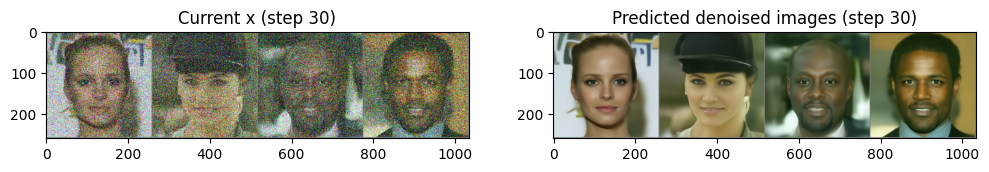

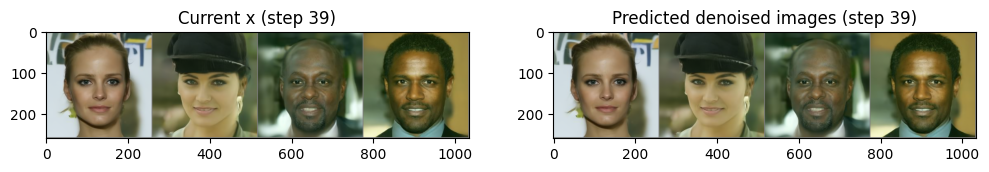

In [10]:
# 随机噪声，batch_size=4，3通道，长宽均为256像素的一组图像
x = torch.randn(4, 3, 256, 256).to(device)

# 循环时间步
for i, t in tqdm(enumerate(scheduler.timesteps)):
    # 给带噪图像加上时间步信息
    model_input = scheduler.scale_model_input(x, t)
    
    # 预测噪声
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    
    # 使用调度器计算更新的样本
    scheduler_output = scheduler.step(noise_pred, t, x)

    # 更新输入图像
    x = scheduler_output.prev_sample
    
    # 绘制输入图像和预测的去噪图像
    if i % 10 == 0 or i == len(scheduler.timesteps) - 1:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        grid = torchvision.utils.make_grid(x, nrow=4).permute(1, 2, 0)
        axs[0].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[0].set_title(f"Current x (step {i})")

        pred_x0 = scheduler_output.pred_original_sample  
        grid = torchvision.utils.make_grid(pred_x0, nrow=4).permute(1, 2, 0)
        axs[1].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[1].set_title(f"Predicted denoised images (step {i})")
        plt.show()

随着过程的推进，预测图像的效果逐步得到改善。

  0%|          | 0/40 [00:00<?, ?it/s]

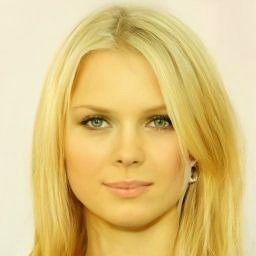

In [17]:
image_pipe.scheduler = scheduler
images = image_pipe(num_inference_steps=40).images
images[0]

## 5.4 微调

In [19]:
dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(dataset_name, split="train")

image_size = 256
batch_size = 4
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Repo card metadata block was not found. Setting CardData to empty.


Previewing batch:


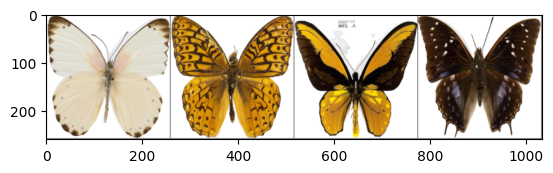

In [20]:
print("Previewing batch:")
batch = next(iter(train_dataloader))
grid = torchvision.utils.make_grid(batch["images"], nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

  0%|          | 0/250 [00:00<?, ?it/s]

E:\LearningDisk\Learning_Projects\MyPythonProjects\my-team-learning\venv\lib\site-packages\diffusers\configuration_utils.py:134: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDIMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDIMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 0 average loss: 0.014798077383427881


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1 average loss: 0.012691656783688814


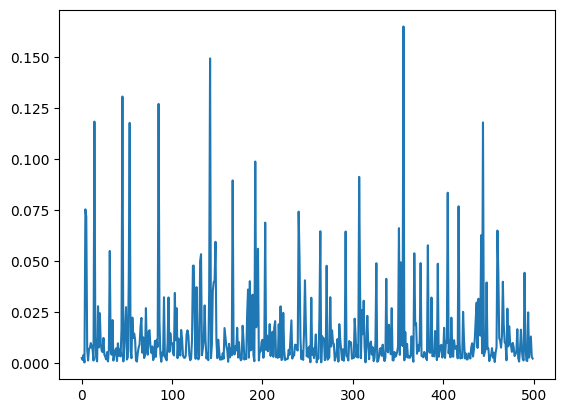

In [21]:
num_epochs = 2
lr = 1e-5
grad_accumulation_steps = 2  

optimizer = torch.optim.AdamW(image_pipe.unet.parameters(), lr=lr)

losses = []

for epoch in range(num_epochs):
    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        clean_images = batch["images"].to(device)
        # 随机生成一个噪声
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]
        # 随机选取一个时间步
        timesteps = torch.randint(
            0,
            image_pipe.scheduler.conf.num_train_timesteps,
            (bs,),
            device=clean_images.device,
        ).long()
        
        # 添加噪声，前向扩散过程
        noisy_images = image_pipe.scheduler.add_noise(clean_images, noise, timesteps)
        # 使用“带噪”图像进行网络预测
        noise_pred = image_pipe.unet(noisy_images, timesteps, return_dict=False)[0]

        loss = F.mse_loss(noise_pred, noise)

        losses.append(loss.item())
        # 更新梯度
        loss.backward(loss)

        if (step + 1) % grad_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    print(f"Epoch {epoch} average loss: {sum(losses[-len(train_dataloader):])/len(train_dataloader)}")

# 绘制损失曲线
plt.plot(losses)

0it [00:00, ?it/s]

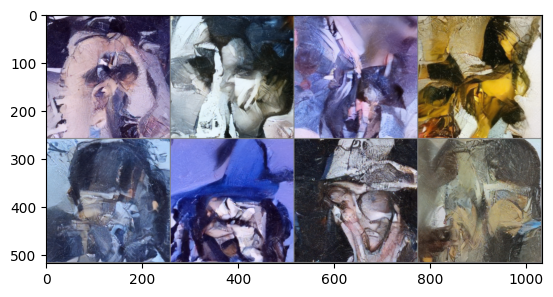

In [23]:
x = torch.randn(8, 3, 256, 256).to(device)
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

## 5.5 引导

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

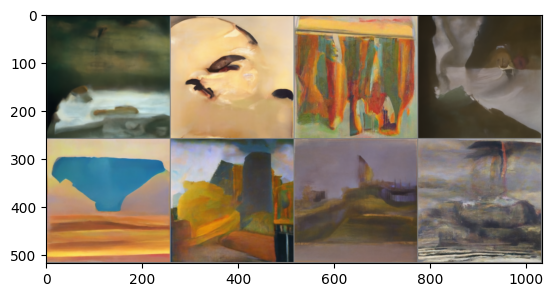

In [26]:
# 加载一个预训练的管线
pipeline_name = "johnowhitaker/sd-class-wikiart-from-bedrooms"
image_pipe = DDPMPipeline.from_pretrained(pipeline_name).to(device)

# 使用DDIM调度器，用40步生成图片
scheduler = DDIMScheduler.from_pretrained(pipeline_name)
scheduler.set_timesteps(num_inference_steps=40)

# 从随机噪声开始
x = torch.randn(8, 3, 256, 256).to(device)

# 使用一个最简单的采样循环
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample

# 生成图片
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

有以下几种情况需要引导：
- 在一个很小的数据集上微调文本条件模型，希望模型尽可能保留其原始训练所学习的内容，以便能够理解数据集中未涵盖的各种文本提示语。希望它能适应我们的数据集，以便生成的内容与原有的数据风格一致，需要使用很小的学习率并对模型执行指数平均操作。
- 可能需要重新训练一个模型以适应新的数据集，需要使用较大的学习率并进行长时间的训练。

### 5.5.1 实战：引导

In [22]:
def color_loss(images, target_color=(0.1, 0.9, 0.5)):
    """给定一个RGB值，返回一个损失值，用于衡量图片的像素值与目标颜色之差"""
    # 归一化
    target = torch.tensor(target_color).to(images.device) * 2 - 1  
    # 将目标张量的形状改未(b, c, h, w)
    target = target[None, :, None, None]  
    # 计算图片的像素值以及目标颜色的均方误差
    error = torch.abs(images - target).mean()  
    return error

方法1：从UNet中获取噪声预测，将其设置为输入图像$x$的requires_grad属性，可以更高效地使用内存。缺点是导致梯度的精度降低。

0it [00:00, ?it/s]

0 loss: 29.17798614501953
10 loss: 12.763346672058105
20 loss: 12.336341857910156
30 loss: 12.545364379882812


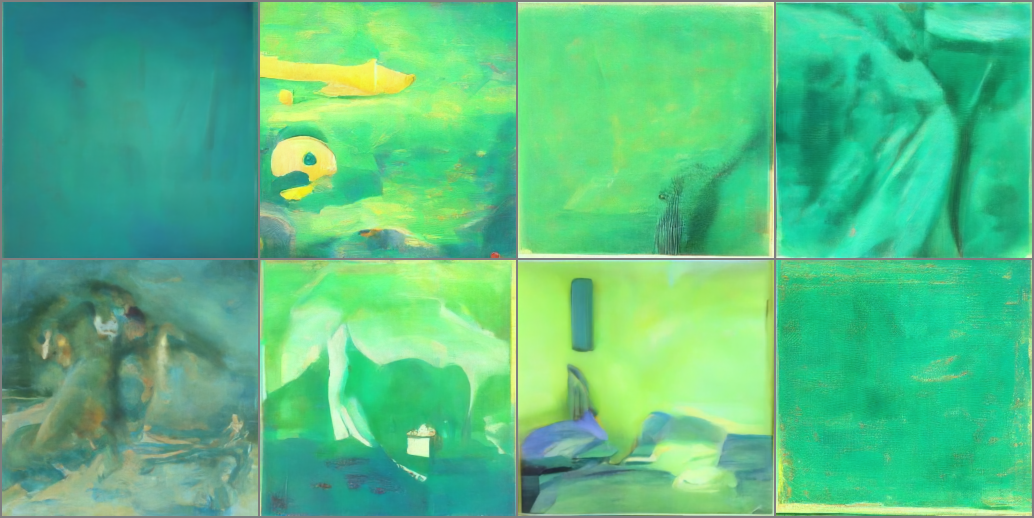

In [27]:

# 用于决定引导的强度有多大，可设置5~100之间的数
guidance_loss_scale = 40  

x = torch.randn(8, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):

    model_input = scheduler.scale_model_input(x, t)

    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    x = x.detach().requires_grad_()
    
    # 得到去噪后的图像
    x0 = scheduler.step(noise_pred, t, x).pred_original_sample

    loss = color_loss(x0) * guidance_loss_scale
    if i % 10 == 0:
        print(i, "loss:", loss.item())
    
    # 获取梯度
    cond_grad = -torch.autograd.grad(loss, x)[0]
    # 梯度更新x
    x = x.detach() + cond_grad
    # 使用调度器更新x
    x = scheduler.step(noise_pred, t, x).prev_sample

grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

方法2：先将输入图像$x$的requires_grad属性设置为True，然后传递给UNet并计算“去噪”后的图像$x_0$。

0it [00:00, ?it/s]

0 loss: 28.346336364746094
10 loss: 14.179899215698242
20 loss: 13.060847282409668
30 loss: 13.248214721679688


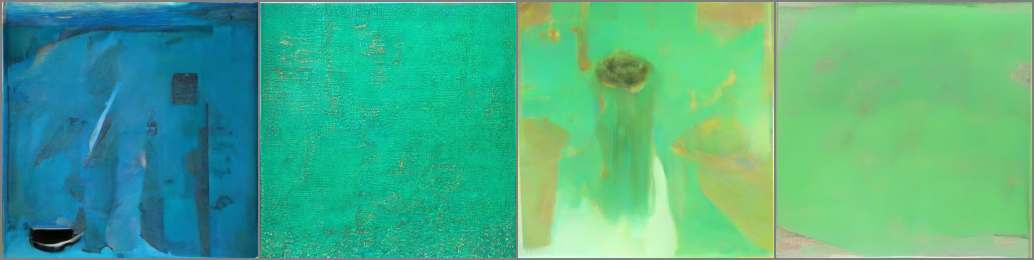

In [28]:
guidance_loss_scale = 40
x = torch.randn(4, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):
    # 设置requires_grad
    x = x.detach().requires_grad_()
    model_input = scheduler.scale_model_input(x, t)
    # 预测
    noise_pred = image_pipe.unet(model_input, t)["sample"]
    # 得到“去噪”后的图像
    x0 = scheduler.step(noise_pred, t, x).pred_original_sample

    loss = color_loss(x0) * guidance_loss_scale
    if i % 10 == 0:
        print(i, "loss:", loss.item())
    # 获取梯度
    cond_grad = -torch.autograd.grad(loss, x)[0]
    # 更新x
    x = x.detach() + cond_grad
    # 使用调度器更新x
    x = scheduler.step(noise_pred, t, x).prev_sample

grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

### 5.5.2 CLIP引导

基本流程：
1. 对文本提示语进行embedding，为 CLIP 获取一个512维的embedding。
2. 在扩散模型的生成过程中的每一步进行如下操作：
   - 制作多个不同版本的预测出来的“去噪”图片。
   - 对预测出来的每一张“去噪”图片，用CLIP给图片做embedding，并对图片和文字的embedding做对比。
   - 计算损失对于当前“带噪”的输入$x$的梯度，在使用调度器更新$x$之前先用这个梯度修改它。

In [30]:
import open_clip

clip_model, _, preprocess = open_clip.create_model_and_transforms("ViT-B-32", pretrained="openai")
clip_model.to(device)

tfms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomResizedCrop(224), 
        torchvision.transforms.RandomAffine(5),  
        torchvision.transforms.RandomHorizontalFlip(),  
        torchvision.transforms.Normalize(
            mean=(0.48145466, 0.4578275, 0.40821073),
            std=(0.26862954, 0.26130258, 0.27577711),
        ),
    ]
)

# 定义一个损失函数，用于获取图片的特征，然后与提示文字的特征进行对比
def clip_loss(image, text_features):
    image_features = clip_model.encode_image(
        tfms(image)
    )  # Note: applies the above transforms
    input_normed = torch.nn.functional.normalize(image_features.unsqueeze(1), dim=2)
    embed_normed = torch.nn.functional.normalize(text_features.unsqueeze(0), dim=2)
    dists = (
        input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
    )  # Squared Great Circle Distance
    return dists.mean()

100%|████████████████████████████████████████| 354M/354M [06:12<00:00, 949kiB/s]


0it [00:00, ?it/s]

E:\LearningDisk\Learning_Projects\MyPythonProjects\my-team-learning\venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Step: 0 , Guidance loss: 7.427663803100586
Step: 25 , Guidance loss: 7.050744533538818


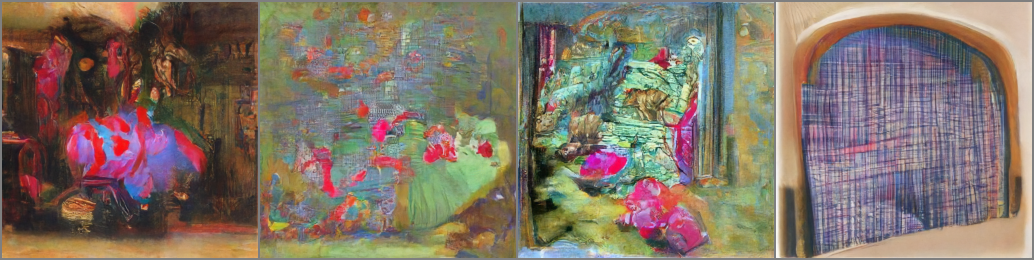

In [31]:
prompt = "Red Rose (still life), red flower painting"

guidance_scale = 8  
n_cuts = 4  

scheduler.set_timesteps(50)

# 使用CLIP从提示文字中提取特征
text = open_clip.tokenize([prompt]).to(device)
with torch.no_grad(), torch.cuda.amp.autocast():
    text_features = clip_model.encode_text(text)


x = torch.randn(4, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):

    model_input = scheduler.scale_model_input(x, t)

    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    cond_grad = 0

    for cut in range(n_cuts):

        x = x.detach().requires_grad_()
        # 获取“去噪”后的图像
        x0 = scheduler.step(noise_pred, t, x).pred_original_sample

        loss = clip_loss(x0, text_features) * guidance_scale
        # 获取梯度并使用n_cuts平均
        cond_grad -= torch.autograd.grad(loss, x)[0] / n_cuts

    if i % 25 == 0:
        print("Step:", i, ", Guidance loss:", loss.item())

    alpha_bar = scheduler.alphas_cumprod[i]
    x = x.detach() + cond_grad * alpha_bar.sqrt()

    x = scheduler.step(noise_pred, t, x).prev_sample


grid = torchvision.utils.make_grid(x.detach(), nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

## 5.6 实战：创建一个类别条件扩散模型

### 5.6.1 配置和数据准备

In [33]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([2, 2, 8, 8, 5, 7, 8, 1])


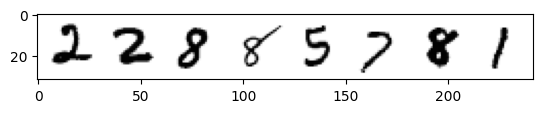

In [37]:
# 加载MNIST数据集
dataset = torchvision.datasets.MNIST(root="./data/mnist/", train=True, 
                                     download=True, 
                                     transform=torchvision.transforms.ToTensor())

train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

### 5.6.2 创建一个以类别为条件的UNet模型

输入类别的流程：
1. 创建一个标准的UNet2DModel，加入一些额外的输入通道。
2. 通过一个嵌入层，把类别标签映射到一个长度为`class_emb_size`的特征向量上。
3. 把这个信息作为额外通道和原有的输入向量拼接起来。
4. 将`net_input`（其中包含class_emb_size + 1个通道）输入UNet模型，得到最终的预测结果。

In [38]:
class ClassConditionedUnet(nn.Module):
    def __init__(self, num_classes=10, class_emb_size=4):
        super().__init__()
        
        self.class_emb = nn.Embedding(num_classes, class_emb_size)

        self.model = UNet2DModel(
            sample_size=28,           
            in_channels=1 + class_emb_size, # 加入额外的输入通道
            out_channels=1,           # 输出结果的通道数
            layers_per_block=2,       # 残差层个数
            block_out_channels=(32, 64, 64), 
            down_block_types=( 
                "DownBlock2D",        # 下采样模块
                "AttnDownBlock2D",    # 含有spatil self-attention的ResNet下采样模块
                "AttnDownBlock2D",
            ), 
            up_block_types=(
                "AttnUpBlock2D", 
                "AttnUpBlock2D",      # 含有spatil self-attention的ResNet上采样模块
                "UpBlock2D",          # 上采样模块
              ),
        )

    def forward(self, x, t, class_labels):
        bs, ch, w, h = x.shape
        # 类别条件将会以额外通道的形式输入
        class_cond = self.class_emb(class_labels) 
        class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)

        net_input = torch.cat((x, class_cond), 1) # (bs, 5, 28, 28)

        return self.model(net_input, t).sample # (bs, 1, 28, 28)

### 5.6.3 训练和采样

  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 0. Average of the last 100 loss values: 0.054008


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 1. Average of the last 100 loss values: 0.046236


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 2. Average of the last 100 loss values: 0.043718


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 3. Average of the last 100 loss values: 0.042421


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 4. Average of the last 100 loss values: 0.042616


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 5. Average of the last 100 loss values: 0.040943


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 6. Average of the last 100 loss values: 0.040841


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 7. Average of the last 100 loss values: 0.039360


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 8. Average of the last 100 loss values: 0.039343


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 9. Average of the last 100 loss values: 0.038989


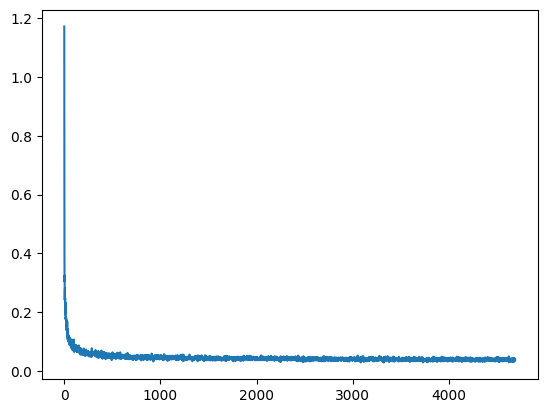

In [40]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

n_epochs = 10

net = ClassConditionedUnet().to(device)

loss_fn = nn.MSELoss()

opt = torch.optim.Adam(net.parameters(), lr=1e-3) 

losses = []

for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):
        
        x = x.to(device) * 2 - 1 
        y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        pred = net(noisy_x, timesteps, y) 

        loss = loss_fn(pred, noise) 

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())

    avg_loss = sum(losses[-100:])/100
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

plt.plot(losses)

0it [00:00, ?it/s]

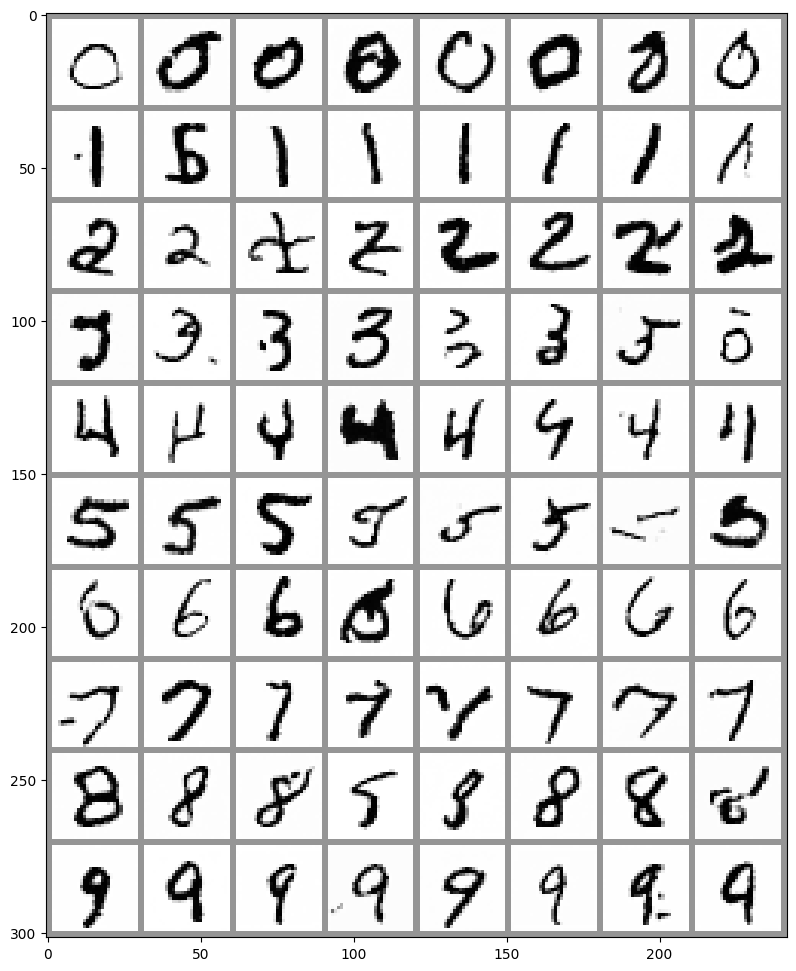

In [41]:
# 准备一个随机噪声作为起点，并准备想要的图片标签
x = torch.randn(80, 1, 28, 28).to(device)
y = torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)

# 循环采样
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    with torch.no_grad():
        residual = net(x, t, y)

    x = noise_scheduler.step(residual, t, x).prev_sample

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap='Greys')